## Introdução
Estudo de caso de análise de risco para empresa de cartão de crédito.
- Problemas: 
  1. Qual o risco que a empresa corre ao emprestar dinheiro a um cliente?
  2. Como posso conhecer melhor o perfil dos meus clientes em relação ao comportamento com o cartão?

- Solução: agrupar clientes e analisar as métricas dos grupos formados.
- Método: utilizar o modelo de aprendizado não supervisionado KMeans do scikit-learn para agrupar os clientes e entender as características de cada grupo.

### Imports

In [1]:
# 1 - AED e Engenharia de dados
import pandas as pd
from sklearn.preprocessing import Normalizer

# 2 - Clusterização
from sklearn.cluster import KMeans
from sklearn import metrics

# 3 - Comparando e Validando
import numpy as np

# 4 - Visualizando e analisando
import matplotlib.pyplot as plt
import seaborn as sns

## 1 - AED e Engenharia de dados


### Head e Describe

In [2]:
dataframe = pd.read_csv('CC GENERAL.csv')
dataframe.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
dataframe.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


### Missing values

In [4]:
# Função para criar tabela de missing values
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

In [5]:
missing_values_table(dataframe)

Your selected dataframe has 18 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
MINIMUM_PAYMENTS,313,3.5
CREDIT_LIMIT,1,0.0


In [6]:
# Dados faltantes preenchidos com a mediana
dataframe.fillna(dataframe.median(), inplace = True)
missing_values_table(dataframe)

Your selected dataframe has 18 columns.
There are 0 columns that have missing values.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


,Missing Values,% of Total Values


### Drop

In [7]:
# Removendo colunas desnecessárias
dataframe.drop(columns = ['CUST_ID', 'TENURE'], inplace = True)

### Normalizando

In [8]:
# Normalizando os dados com função do sklearn
values = Normalizer().fit_transform(dataframe.values)
values

array([[3.93555441e-02, 7.87271593e-04, 9.17958473e-02, ...,
        1.94178127e-01, 1.34239194e-01, 0.00000000e+00],
       [2.93875903e-01, 8.34231560e-05, 0.00000000e+00, ...,
        3.76516684e-01, 9.84037959e-02, 2.03923046e-05],
       [3.10798149e-01, 1.24560965e-04, 9.63068011e-02, ...,
        7.74852335e-02, 7.81351982e-02, 0.00000000e+00],
       ...,
       [2.27733092e-02, 8.11060955e-04, 1.40540698e-01, ...,
        7.90986945e-02, 8.02156174e-02, 2.43318384e-04],
       [2.65257948e-02, 1.64255731e-03, 0.00000000e+00, ...,
        1.03579625e-01, 1.09898221e-01, 4.92767391e-04],
       [1.86406219e-01, 3.33426837e-04, 5.46778061e-01, ...,
        3.15915455e-02, 4.41568390e-02, 0.00000000e+00]])

## 2 - Clusterização

###Gerando os Clusters

In [9]:
kmeans = KMeans(n_clusters=5, n_init = 10, max_iter=300) #n_init: diz que o algorítmo deve retornar 10x seguidas o mesmo valor
y_pred = kmeans.fit_predict(values)

### Validando os clusters com Silhouette
Varia de -1 a 1 e quanto mais próximo de 1 melhor

In [10]:
labels = kmeans.labels_
silhouette = metrics.silhouette_score(values, labels, metric = 'euclidean')
print(silhouette)

0.34852928204523576


### Validando com Davies_bouldin
É sempre positivo e quanto menor melhor

In [11]:
dbs = metrics.davies_bouldin_score(values, labels)
print(dbs)

1.1527134855876946


### Validando com Calinski-Harabasz
Quanto maior melhor. 

Serve para comparar uma divisão de clusters com a outra, mas o número sozinho não diz muita coisa

In [12]:
calinski = metrics.calinski_harabasz_score(values, labels)
calinski

3422.838208337745

### Função para calcular todos os índices de uma só vez

In [13]:
# Calcula COM normalização para um vetor clusters
def clustering_algorithm(array_nclusters, dataset):
  #Normalizando
  values = Normalizer().fit_transform(dataset.values)
  matrix = {}
  matrix['Tipo'] = ['Silhouette','DBS','Calinski']
  for nclusters in array_nclusters:
    linha = []
    #Kmeans
    kmeans = KMeans(n_clusters=nclusters, n_init = 10, max_iter=300) #n_init: diz q o algorítmo deve retornar 10x seguidas o mesmo valor
    y_pred = kmeans.fit_predict(values)
    labels = kmeans.labels_

    #Silhouette
    silhouette = metrics.silhouette_score(values, labels, metric = 'euclidean')
    linha.append(silhouette)
    #DBS
    dbs = metrics.davies_bouldin_score(values, labels)
    linha.append(dbs)

    #Calinski
    calinski = metrics.calinski_harabasz_score(values, labels)
    linha.append(calinski)

    matrix[nclusters] = linha
  display(pd.DataFrame.from_dict(matrix))


In [14]:
# Calcula SEM NORMALIZAÇÃO para um vetor clusters
def clustering_algorithm_sem_normalizacao(array_nclusters, dataset):
  values = dataset
  matrix = {}
  matrix['Tipo'] = ['Silhouette','DBS','Calinski']
  for nclusters in array_nclusters:
    linha = []
    #Kmeans
    kmeans = KMeans(n_clusters=nclusters, n_init = 10, max_iter=300) #n_init: diz q o algorítmo deve retornar 10x seguidas o mesmo valor
    y_pred = kmeans.fit_predict(values)
    labels = kmeans.labels_

    #Silhouette
    silhouette = metrics.silhouette_score(values, labels, metric = 'euclidean')
    linha.append(silhouette)
    #DBS
    dbs = metrics.davies_bouldin_score(values, labels)
    linha.append(dbs)

    #Calinski
    calinski = metrics.calinski_harabasz_score(values, labels)
    linha.append(calinski)

    matrix[nclusters] = linha
  display(pd.DataFrame.from_dict(matrix))


In [15]:
clustering_algorithm([3,5,10,50], dataframe)

,Tipo,3,5,10,50
0,Silhouette,0.327220,0.364508,0.351445,0.263125
1,DBS,1.309607,1.075652,1.115909,1.225862
2,Calinski,3526.440520,3431.797438,3019.197231,1612.604084


## 3 - Comparando e Validando

### Comparando com um dataset de valores aleatórios

In [16]:
# Criando dataset aleatório com numpy
random_data = np.random.rand(8950,16)
clustering_algorithm_sem_normalizacao([3,5], random_data)

,Tipo,3,5
0,Silhouette,0.040042,0.039166
1,DBS,4.003086,3.539732
2,Calinski,373.729752,300.341834


### Validando a estabilidade dos clusters

In [17]:
# Dividindo em 3 datasets
set1, set2, set3 = np.array_split(values, 3)
clustering_algorithm_sem_normalizacao([3,5], set1)
print('\n')
clustering_algorithm_sem_normalizacao([3,5], set2)
print('\n')
clustering_algorithm_sem_normalizacao([3,5], set3)


,Tipo,3,5
0,Silhouette,0.325127,0.368678
1,DBS,1.294265,1.059133
2,Calinski,1171.693736,1204.060256


,Tipo,3,5
0,Silhouette,0.336245,0.35390
1,DBS,1.323734,1.13877
2,Calinski,1223.942295,1194.95568


,Tipo,3,5
0,Silhouette,0.333178,0.367036
1,DBS,1.291039,1.099377
2,Calinski,1187.652573,1167.531383


## 4 - Visualizando e analisando

<function matplotlib.pyplot.show>

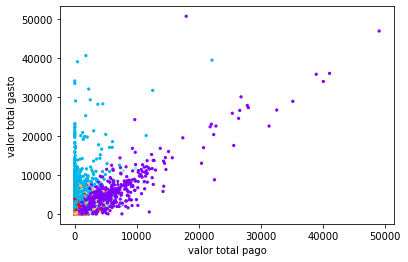

In [18]:
plt.scatter(dataframe['PURCHASES'], dataframe['PAYMENTS'], c=labels, s=5, cmap='rainbow' ) #s é o tamanho dos pontos
plt.xlabel("valor total pago")
plt.ylabel("valor total gasto")
plt.show

### Agrupando por cluster

In [19]:
dataframe["cluster"] = labels
dataframe.groupby("cluster").describe()

BALANCE                                                     \
          count         mean          std         min          25%   
cluster                                                              
0        1498.0  1117.171407  1625.342446    0.000000   211.969616   
1        1001.0  1748.854674  1987.975020    0.000000   486.170360   
2        1825.0  2949.582558  2565.494710  114.523682  1216.893766   
3        3311.0   488.867396   936.898299    0.000000    24.007416   
4        1315.0  2719.616192  2230.337145    1.691842  1035.647960   

                                                BALANCE_FREQUENCY            \
                 50%          75%           max             count      mean   
cluster                                                                       
0         541.983437  1335.364048  19043.138560            1498.0  0.931526   
1        1060.422892  2241.092286  14581.459140            1001.0  0.858535   
2        1843.308668  4021.881912  18495.558550            1825.0  0.996860   
3          85.285023   448.965814   9630.367575            3311.0  0.780708   
4        2080.312991  3782.283750  12856.152510            1315.0  0.906890   

         ... MINIMUM_PAYMENTS               PRC_FULL_PAYMENT            \
         ...              75%           max            count      mean   
cluster  ...                                                             
0        ...       530.447980  18621.013310           1498.0  0.282255   
1        ...       931.105425  21235.065300           1001.0  0.129974   
2        ...      1961.161822  76406.207520           1825.0  0.001062   
3        ...       260.172137   3933.230932           3311.0  0.244968   
4        ...      1164.174894   8644.138069           1315.0  0.007450   

                                                           
              std  min  25%       50%       75%       max  
cluster                                                    
0        0.369040  0.0  0.0  0.083333  0.567461  1.000000  
1        0.198876  0.0  0.0  0.083333  0.166667  1.000000  
2        0.013400  0.0  0.0  0.000000  0.000000  0.416667  
3        0.345935  0.0  0.0  0.000000  0.436507  1.000000  
4        0.041141  0.0  0.0  0.000000  0.000000  0.600000  

[5 rows x 128 columns]

### Analisando os atributos para selecionar os mais importantes

In [20]:
dataframe.columns.values

array(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'cluster'], dtype=object)

In [21]:
# Pega o centro de cada cluster
centroids = kmeans.cluster_centers_

# Vejamos a variância de cada atributo entre os clusters, em ordem decrescente
max = len(centroids[0])
tabela_variancia = {}
for i in range(max):
  tabela_variancia[dataframe.columns.values[i]]=[centroids[:, i].var()]
tabela_variancia = pd.DataFrame.from_dict(data=tabela_variancia).T.rename({0:'variância'}, axis=1)
tabela_variancia = tabela_variancia.sort_values(by=['variância'], ascending = False)
tabela_variancia

,variância
CASH_ADVANCE,3.507047e-02
PAYMENTS,3.477665e-02
BALANCE,2.762910e-02
PURCHASES,2.184680e-02
CREDIT_LIMIT,2.095103e-02
MINIMUM_PAYMENTS,7.835716e-03
ONEOFF_PURCHASES,7.701346e-03
INSTALLMENTS_PURCHASES,3.726913e-03
PURCHASES_TRX,3.595285e-06
CASH_ADVANCE_TRX,4.295585e-07


Selecionados os 6 primeiros:

In [22]:
tabela_variancia.head(6)

,variância
CASH_ADVANCE,0.035070
PAYMENTS,0.034777
BALANCE,0.027629
PURCHASES,0.021847
CREDIT_LIMIT,0.020951
MINIMUM_PAYMENTS,0.007836


### Tabela de parâmetros por clusters

In [23]:
# Data frame dos parâmetros principais agrupados por cluster
description = dataframe.groupby("cluster")["BALANCE", "PURCHASES", "CASH_ADVANCE", "CREDIT_LIMIT", "PAYMENTS"]


# Tabela formatada com os parâmetros principais por cluster
n_clients = description.size()
description = round(description.mean(),2)
description.columns = ['Divida', 'Compras', 'Saques', 'Limite_de_Credito', 'Pagamentos']
description['%_Clientes'] = n_clients/len(dataframe)*100
description.style.format('{:,.2f}').background_gradient(cmap='Blues').background_gradient(subset=['Divida'],cmap='Reds')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Divida,Compras,Saques,Limite_de_Credito,Pagamentos,%_Clientes
cluster,,,,,,
0,"1,117.17","3,323.69",185.51,"4,043.60","3,045.85",16.74
1,"1,748.85",531.25,"3,064.44","3,914.96","4,961.22",11.18
2,"2,949.58",559.48,573.50,"3,730.00","1,050.32",20.39
3,488.87,639.14,126.25,"5,180.29",827.30,36.99
4,"2,719.62",251.53,"3,004.45","4,782.09","1,008.92",14.69


## Descrição das característica dos clusters
CLUSTER 0: Clientes mais individados. Menor limite de crédito. Contempla boa parte dos clientes (20%). Risco Alto.

CLUSTER 1: Maior valor em saques e em pagamentos. Grupo minoritário (11%). Risco baixo.

CLUSTER 2: Clientes que menos gastam. Têm o maior limite. São o maior grupo (37%). Risco baixo.

CLUSTER 3: Clientes com maior valor em compras com grande diferença. Risco médio.

CLUSTER 4: Clientes que gastam e sacam bastante. Limite de crédito alto. Risco alto.